In [1]:

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    f1_score, precision_score, recall_score
)
import joblib

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [3]:

DATA_PATH = "/content/Consumer_Complaints.csv"

df = pd.read_csv(DATA_PATH)

possible_text_cols = [
    'Consumer complaint narrative', 'consumer_complaint_narrative',
    'Complaint', 'consumer_complaint', 'complaint_what_happened'
]
text_col = next((c for c in possible_text_cols if c in df.columns), None)
if text_col is None:

    candidate = [c for c in df.columns if 'narrative' in c.lower() or 'complaint' in c.lower()]
    text_col = candidate[0] if candidate else df.columns[0]
print("Using text column:", text_col)

def map_category(prod):
    s = str(prod).lower()
    loan_keywords = ['consumer loan', 'student loan', 'payday loan', 'vehicle loan', 'personal loan', 'installment loan']
    if 'credit reporting' in s or 'credit repair' in s or 'credit reporting' in s:
        return 0
    elif 'debt collection' in s or 'debt collector' in s:
        return 1
    elif any(k in s for k in loan_keywords):
        return 2
    elif 'mortgage' in s or 'mortgage servicing' in s:
        return 3
    else:
        return np.nan

prod_col = 'Product' if 'Product' in df.columns else next((c for c in df.columns if 'product' in c.lower()), 'Product')
df['label'] = df[prod_col].apply(map_category)
df = df.dropna(subset=['label']).copy()
df['label'] = df['label'].astype(int)

df['text'] = df[text_col].fillna("").astype(str)
df['text_len'] = df['text'].str.len()
print("Label distribution:\n", df['label'].value_counts())
print("Sample rows:\n", df[['label', 'text_len']].head())



Using text column: Consumer complaint narrative
Label distribution:
 label
0    3565
1    2995
3    1925
2    1683
Name: count, dtype: int64
Sample rows:
    label  text_len
0      0         0
1      1         0
3      3         0
5      1         0
6      3         0


In [4]:

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(s):
    s = str(s).lower()
    s = re.sub(r"http\S+|www\S+", " ", s)
    s = re.sub(r"\S+@\S+", " ", s)
    s = re.sub(r"[^a-z\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    tokens = [w for w in s.split() if w not in stop_words and len(w) > 1]
    lemmed = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(lemmed)


df['clean_text'] = df['text'].map(preprocess_text)

for orig, clean in df[['text','clean_text']].head(5).values:
    print("ORIG:", orig[:120].replace("\n"," "), "\nCLEAN:", clean[:120], "\n---")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


ORIG:  
CLEAN:  
---
ORIG:  
CLEAN:  
---
ORIG:  
CLEAN:  
---
ORIG:  
CLEAN:  
---
ORIG:  
CLEAN:  
---


In [5]:

X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE),
    "Naive Bayes": MultinomialNB(),
    "SVM": LinearSVC(class_weight='balanced', max_iter=20000, random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE)
}


pipelines = {
    name: Pipeline([
        ('tfidf', TfidfVectorizer(ngram_range=(1,2), max_features=20000)),
        ('clf', model)
    ]) for name, model in models.items()
}


In [6]:

results = []
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, pipe in pipelines.items():
    print(f"\nTraining {name} ...")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    prec = precision_score(y_test, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_test, y_pred, average='macro', zero_division=0)

    try:
        cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='f1_macro', n_jobs=-1)
        cv_mean = cv_scores.mean()
    except Exception as e:
        cv_mean = np.nan
    print(f"{name} -> Acc: {acc:.4f}, F1_macro: {f1:.4f}, CV_f1_mean: {cv_mean:.4f}")
    print(classification_report(y_test, y_pred, digits=4))
    results.append({
        'model': name, 'pipeline': pipe, 'accuracy': acc,
        'f1_macro': f1, 'precision_macro': prec, 'recall_macro': rec,
        'cv_f1_mean': cv_mean
    })

results_df = pd.DataFrame(results).sort_values(by='f1_macro', ascending=False).reset_index(drop=True)
print("\nModel comparison:\n", results_df[['model','accuracy','f1_macro','cv_f1_mean']])



Training Logistic Regression ...
Logistic Regression -> Acc: 0.4690, F1_macro: 0.3859, CV_f1_mean: 0.3625
              precision    recall  f1-score   support

           0     0.4002    0.9762    0.5677       713
           1     0.8981    0.1619    0.2744       599
           2     0.8182    0.3205    0.4606       337
           3     0.9636    0.1377    0.2409       385

    accuracy                         0.4690      2034
   macro avg     0.7700    0.3991    0.3859      2034
weighted avg     0.7228    0.4690    0.4017      2034


Training Naive Bayes ...
Naive Bayes -> Acc: 0.4577, F1_macro: 0.3577, CV_f1_mean: 0.3426
              precision    recall  f1-score   support

           0     0.3999    0.9776    0.5676       713
           1     0.7500    0.1753    0.2842       599
           2     0.8151    0.2878    0.4254       337
           3     1.0000    0.0831    0.1535       385

    accuracy                         0.4577      2034
   macro avg     0.7413    0.3810    0.35

Best model: SVM


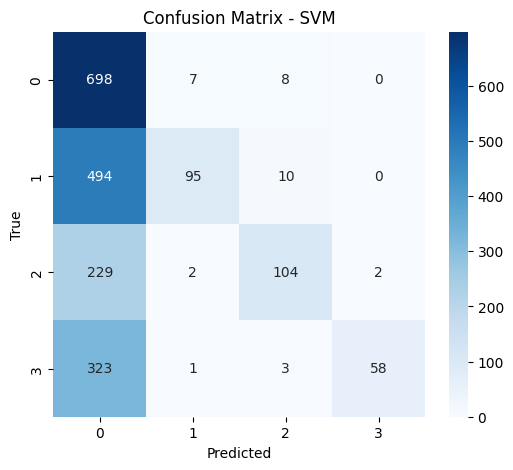

Classification report for best model:

              precision    recall  f1-score   support

           0     0.4002    0.9790    0.5682       713
           1     0.9048    0.1586    0.2699       599
           2     0.8320    0.3086    0.4502       337
           3     0.9667    0.1506    0.2607       385

    accuracy                         0.4695      2034
   macro avg     0.7759    0.3992    0.3872      2034
weighted avg     0.7276    0.4695    0.4026      2034


Top positive features for class 0:
['equifax', 'experian', 'report', 'transunion', 'inquiry', 'information', 'belong', 'removed', 'fcra', 'fraud', 'incorrect', 'dispute', 'hard', 'error', 'xxxx reported']

Top positive features for class 1:
['debt', 'collection', 'bill', 'owe', 'call', 'medical', 'recovery', 'collect', 'validation', 'stop', 'service', 'calling', 'account verified', 'amount', 'owed']

Top positive features for class 2:
['navient', 'loan', 'car', 'finance', 'nelnet', 'interest', 'vehicle', 'payment', 'sch

In [7]:

best_row = results_df.iloc[0]
best_name = best_row['model']
best_pipe = best_row['pipeline']
print("Best model:", best_name)

y_pred_best = best_pipe.predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0,1,2,3], yticklabels=[0,1,2,3])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix - {best_name}")
plt.show()

print("Classification report for best model:\n")
print(classification_report(y_test, y_pred_best, digits=4))

try:
    vect = best_pipe.named_steps['tfidf']
    clf = best_pipe.named_steps['clf']
    feature_names = vect.get_feature_names_out()
    if hasattr(clf, 'coef_'):
        coefs = clf.coef_

        for i, class_idx in enumerate(range(coefs.shape[0])):
            topn = np.argsort(coefs[i])[-15:][::-1]
            print(f"\nTop positive features for class {i}:")
            print([feature_names[j] for j in topn[:15]])
except Exception:
    pass


joblib.dump(best_pipe, "best_text_classifier.joblib")
print("Saved best model to best_text_classifier.joblib")


In [8]:

category_mapping = {
    0: "Credit reporting, repair, or other",
    1: "Debt collection",
    2: "Consumer Loan",
    3: "Mortgage"
}


print("0 Credit reporting, repair, or other")
print("1 Debt collection")
print("2 Consumer Loan")
print("3 Mortgage")


samples = [
    "I got billed incorrectly for my credit report and cannot fix my file",
    "Debt collector keeps calling me for an old debt that I don't owe",
    "I applied for a personal loan but was charged unexpected fees",
    "My mortgage servicer applied my payments to the wrong account"
]


def predict_and_print(pipe, samples):
    for s in samples:
        s_clean = preprocess_text(s)
        pred = pipe.predict([s_clean])[0]
        print(f"Input: {s}\nPrediction: {pred} {category_mapping[pred]}\n")

predict_and_print(best_pipe, samples)


0 Credit reporting, repair, or other
1 Debt collection
2 Consumer Loan
3 Mortgage
Input: I got billed incorrectly for my credit report and cannot fix my file
Prediction: 0 Credit reporting, repair, or other

Input: Debt collector keeps calling me for an old debt that I don't owe
Prediction: 1 Debt collection

Input: I applied for a personal loan but was charged unexpected fees
Prediction: 2 Consumer Loan

Input: My mortgage servicer applied my payments to the wrong account
Prediction: 3 Mortgage

